In [1]:
%load_ext blackcellmagic
%matplotlib inline

In [2]:
from matplotlib import style

style.use("fivethirtyeight")
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [7]:
table_names = inspector.get_table_names()
table_names

['measurement', 'station']

In [8]:
for table in table_names:
    print(table + ":")
    columns = inspector.get_columns(table)
    column_names = [column["name"] for column in columns]
    print(column_names)

measurement:
['id', 'station', 'date', 'prcp', 'tobs']
station:
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

* Calculate the date 1 year ago from the last data point in the database

* Perform a query to retrieve the data and precipitation scores

* Save the query results as a Pandas DataFrame and set the index to the date column

* Sort the dataframe by date

* Use Pandas Plotting with Matplotlib to plot the data

In [13]:
session.query(Measurement.date).count()

19550

In [14]:
print(engine.execute("SELECT * FROM measurement ORDER BY date DESC").first())

(2724, 'USC00519397', '2017-08-23', 0.0, 81.0)


In [15]:
last_data_point = (
    session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
)

In [16]:
last_data_point

'2017-08-23'

In [17]:
# last_year = dt.datetime.strptime(last_data_point, "%Y-%m-%d") - dt.timedelta(days=365)

In [18]:
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [19]:
prcp_last_year = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= last_year)
    .order_by(Measurement.date)
    .all()
)

In [20]:
prcp_last_year_df = pd.DataFrame(prcp_last_year).set_index("date")

In [21]:
prcp_last_year_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


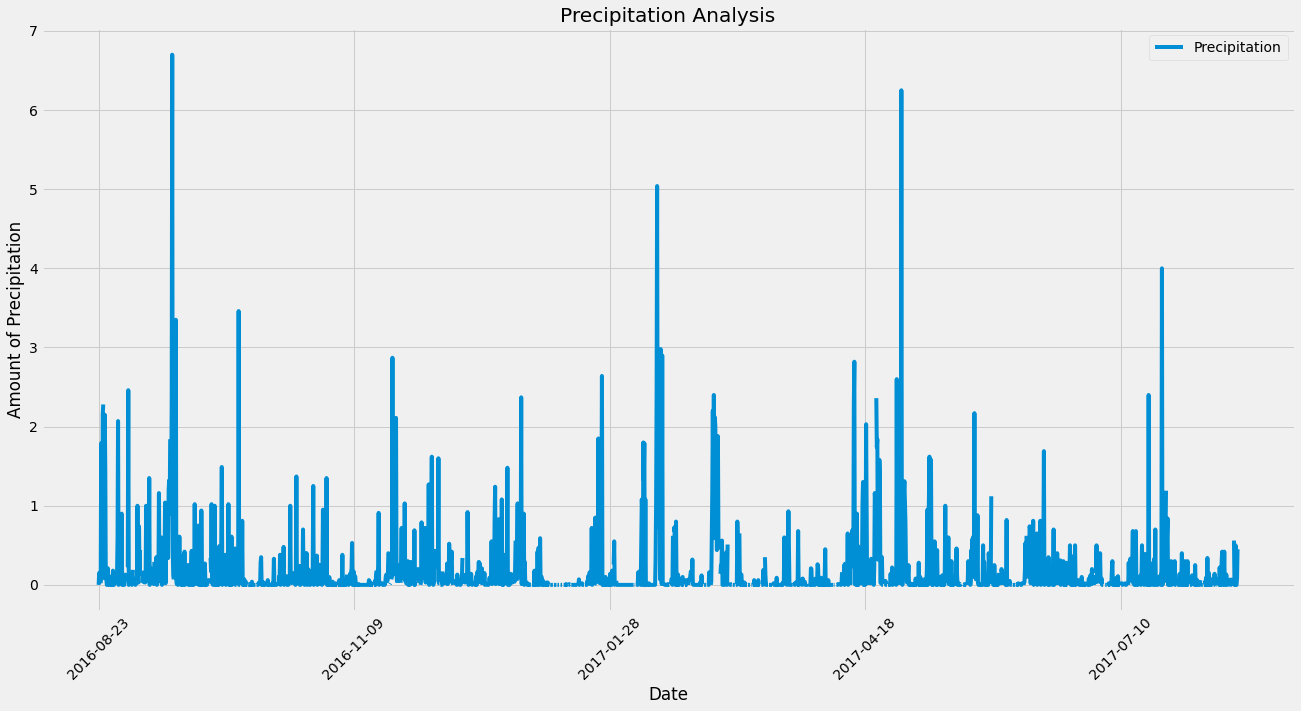

In [22]:
prcp_last_year_df.plot(y="prcp", use_index=True, label="Precipitation")
plt.gcf().set_size_inches(20, 10)
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Amount of Precipitation")
plt.title("Precipitation Analysis")
plt.legend()
plt.show()
plt.close()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_last_year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

* List the stations and observation counts in descending order.

* Which station has the highest number of observations?

* Hint: You may need to use functions such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries.

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

* Filter by the station with the highest number of observations.

* Plot the results as a histogram with `bins=12`.

In [24]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Station.station).count()
print(number_stations)

9


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station?
most_active_station = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == "USC00519281")
    .first()
)

In [27]:
most_active_station

(54.0, 85.0, 71.66378066378067)

In [28]:
# Choose the station with the highest number of temperature observations.
station_most_temps = (
    session.query(Measurement.station, func.count(Measurement.tobs))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .first()
)
print(station_most_temps)

('USC00519281', 2772)


In [29]:
# Query the last 12 months of temperature observation data for this station
temp_last_year = (
    session.query(Measurement.station, Measurement.tobs)
    .filter(Measurement.date >= last_year)
    .filter(Measurement.station == "USC00519281")
    .all()
)

In [30]:
temp_last_year_df = pd.DataFrame(temp_last_year)
temp_last_year_df

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0
...,...,...
347,USC00519281,77.0
348,USC00519281,77.0
349,USC00519281,76.0
350,USC00519281,76.0


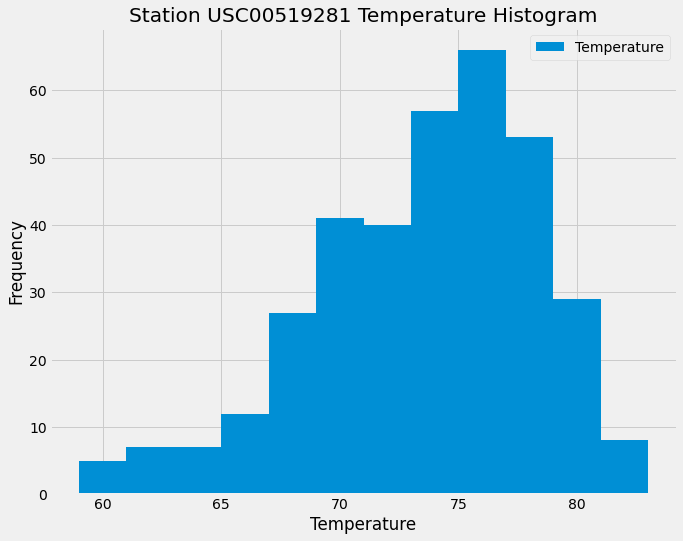

In [31]:
# plot the results as a histogram
temp_last_year_df.plot.hist(bins=12,)
plt.gcf().set_size_inches(10, 8)
plt.xlabel("Temperature")
plt.title("Station USC00519281 Temperature Histogram")
plt.legend(["Temperature"])
plt.show()
plt.close()

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )


# function usage example
print(calc_temps("2012-02-28", "2012-03-05"))

[(62.0, 69.57142857142857, 74.0)]
